In [28]:
import pandas as pd
from fastai.text import *

In [29]:
df_train = pd.read_csv('../data/data_clean/train.csv')
df_val = pd.read_csv('../data/data_clean/val.csv')

In [30]:
df_val.head()

,text,airline_sentiment
0,@USAirways : i was told my ticket expired but ...,negative
1,@USAirways on hold 2.5 hrs trying to reschedul...,negative
2,@AmericanAir I didn't miss my flight. America...,negative
3,@united I would like 2 speak @United VP of #Cu...,negative
4,@JetBlue what's up w flt 4? Brothers fiancé si...,negative


Creating data bunches for the language model and classifier (and saving for later loading the model for inference).

In [31]:
data_lm = TextLMDataBunch.from_df('../data/data_clean', df_train, df_val, text_cols=0, bs=32)
data_clas = TextClasDataBunch.from_df('../data/data_clean', df_train, df_val, text_cols=0, label_cols=1, bs=32)
data_clas.save('data_clas.pkl')

# 1. Language model

In [32]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, pretrained=True, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


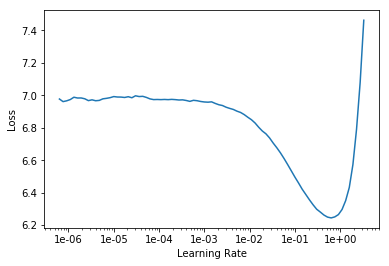

In [33]:
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.575075,4.105463,0.245396,00:14


In [35]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


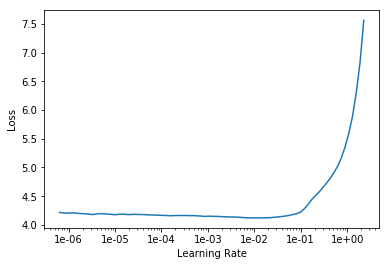

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.065351,3.968871,0.264509,00:19
1,3.927182,3.849734,0.280078,00:20
2,3.780188,3.768497,0.286579,00:20
3,3.575598,3.718272,0.291546,00:20
4,3.380581,3.705634,0.293471,00:20
5,3.186193,3.717342,0.293834,00:20
6,3.024663,3.739004,0.294643,00:20
7,2.881984,3.760186,0.293304,00:20
8,2.791999,3.777568,0.292048,00:20
9,2.754145,3.783827,0.292188,00:20


In [38]:
learn.save('twitter-sentiment-lm')

Let's see how my language model generates new sentences:

In [39]:
TEXT = "I didn't like "
N_WORDS = 50
N_SENTENCES = 1

In [40]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I didn't like  the website . Is there a way to do this ? xxbos @americanair i called and it hangs up . How do i get my agent , no call back , and no response ? xxbos @southwestair So it 's nice to be honest , but you


In [41]:
learn.save_encoder('twitter-sentiment-enc')

# 2. Classifier

In [42]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, pretrained=True, drop_mult=0.3)
learn.load_encoder('twitter-sentiment-enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


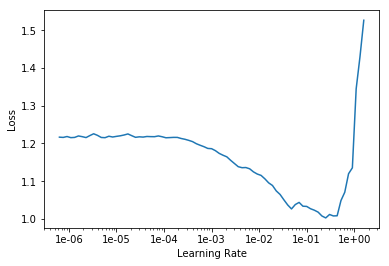

In [43]:
learn.lr_find()
learn.recorder.plot()

In [44]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.632755,0.514343,0.786897,00:10


In [45]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.553833,0.451796,0.815862,00:12


In [46]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.514303,0.427140,0.828966,00:19


In [47]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.452545,0.412979,0.837931,00:27
1,0.421069,0.419779,0.835862,00:25


In [48]:
learn.predict(" I loved my flight")

(Category positive, tensor(2), tensor([0.0044, 0.0018, 0.9937]))

Save the model:

In [49]:
learn.save('twitter-sentiment-classifier')